In [ ]:
import os
import numpy as np
import glob, yaml
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, f1_score, accuracy_score
import segmentation_loader
from gnn_v2 import Action_GNN, Body_GNN
import SupConLoss, barlow 
from torch.nn.utils import spectral_norm
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from util import std_by_channel 

import warnings
warnings.filterwarnings("ignore")
from util import user_segmentation_vis, get_pred

In [7]:

###### GNN + SEG 

torch.manual_seed(0)
torch.cuda.manual_seed(0)


root_dir = "/home/dilab/data/etri/daywise"
test_dir = os.path.join(root_dir, 'test')

epoch = 10 

##### segmentation file path 
action_spatio_file = './saved_models/seg_action_spatio_3_{}epoch.pth'.format((epoch))
body_spatio_file = './saved_models/seg_body_spatio_3_{}epoch.pth'.format((epoch))
linear_file = './saved_models/seg_linear_spatio_3_{}epoch.pth'.format((epoch))

with open('config.yaml','r') as ymlfile:
    cfg = yaml.full_load(ymlfile) 
    action_edge = cfg['action_edge']
    action_edge = torch.tensor(action_edge, dtype=torch.long).t().contiguous()

    body_edge = cfg['body_edge']
    body_edge = torch.tensor(body_edge, dtype=torch.long).t().contiguous()
    
    action_nodes = cfg['action_nodes']
    action_kernel_size = cfg['action_kernel_size']
    action_gnn_outputdim = cfg['action_gnn_outputdim']

    body_nodes = cfg['body_nodes']
    body_kernel_size = cfg['body_kernel_size']
    body_gnn_outputdim = cfg['body_gnn_outputdim']
    classes = cfg['classes']

test_loader = segmentation_loader.dataloader(root_dir = test_dir, batch_size = 1)
action_spatio = Action_GNN(num_nodes = action_nodes, kernel_size = action_kernel_size, out_channels = action_gnn_outputdim, device='cpu')
body_spatio = Body_GNN(num_nodes = body_nodes, kernel_size = body_kernel_size, out_channels = body_gnn_outputdim, device='cpu')
linear = spectral_norm(nn.Linear(action_gnn_outputdim + body_gnn_outputdim, classes))


###############
action_spatio.load_state_dict(torch.load(action_spatio_file))
body_spatio.load_state_dict(torch.load(body_spatio_file))
linear.load_state_dict(torch.load(linear_file))

/home/dilab/data/etri/daywise/test
Conv1d(15, 240, kernel_size=(5,), stride=(1,), groups=15)
Conv1d(240, 480, kernel_size=(5,), stride=(1,), groups=15)
Conv1d(480, 15, kernel_size=(5,), stride=(1,), groups=15)
Conv1d(4, 64, kernel_size=(3,), stride=(1,), groups=4)
Conv1d(64, 4, kernel_size=(3,), stride=(1,), groups=4)


<All keys matched successfully>

In [ ]:
def get_pred(device, f_name, n_iter):
    ################# data load 
    sensor_1 = ['e4Bvp', 'e4Eda', 'e4Hr', 'e4Temp']
    sensor_2 = ['e4Acc_x', 'e4Acc_y', 'e4Acc_z', 'mAcc_x', 'mAcc_y', 'mAcc_z', 
            'mGyr_x', 'mGyr_y', 'mGyr_z', 'mGyr_roll', 'mGyr_pitch', 'mGyr_yaw', 
            'mMag_x', 'mMag_y', 'mMag_z']

    file = np.load(os.path.join(test_dir, f_name))

    x1 = []
    x1 = ([file[ch] for ch in sensor_1])
    x1 = np.stack(x1, axis=0)
    x1 = std_by_channel(x1)
    x1 = torch.from_numpy(x1)
    x2 = []
    x2 = ([file[ch] for ch in sensor_2])
    x2 = np.stack(x2, axis=0)

    x2 = std_by_channel(x2)
    x2 = torch.from_numpy(x2)


    action_label = file['label_action']
    x1_ = x1.permute(1,0,2)
    x2_ = x2.permute(1,0,2)
    y_ = action_label.reshape(-1)

    x1_ = x1_.type(torch.FloatTensor).squeeze(0)
    x2_ = x2_.type(torch.FloatTensor).squeeze(0)
    y_ =  torch.LongTensor(y_).squeeze(0)



    ################## Prediction 
    predlist=torch.zeros(0, dtype=torch.long, device=device)
    lbllist=torch.zeros(0, dtype=torch.long, device=device)  

    batch_loader = segmentation_loader.batchloader(x1_, x2_, y_, y_, batch_size = 128)                
    for iter, (b_x, b_x2, b_target, _) in enumerate(batch_loader):
        if iter == n_iter:
            body_out, body_pred = body_spatio(b_x, edge_index = body_edge) 
            action_out, aciton_pred = action_spatio(b_x2, edge_index = action_edge) 

            lin_in = torch.cat([body_out , action_out], 1)
            pred = linear(lin_in)

            _, predictions = torch.max(pred,-1)
            #print(pred)
            print("Batch accuracy:", accuracy_score(predictions, b_target))
            predlist = torch.cat([predlist, predictions.view(-1)])
            lbllist = torch.cat([lbllist, b_target.view(-1)])

            predlist, lbllist = predlist.to('cpu'), lbllist.to('cpu')
            acc = accuracy_score(lbllist, predlist)

    f1 = f1_score( lbllist, predlist, average='weighted')
    class_f1 = f1_score( lbllist, predlist, average=None)
    report = classification_report(lbllist, predlist, output_dict = False)
    print(acc)
    print(f1)
    print(report)       

    return predlist, lbllist, x1, x2

Batch accuracy: 0.609375
0.609375
0.5628510109114249
              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       1.00      0.03      0.05        37
           2       0.79      0.99      0.88        73
          13       0.62      0.42      0.50        12
          14       0.00      0.00      0.00         6

    accuracy                           0.61       128
   macro avg       0.48      0.29      0.29       128
weighted avg       0.80      0.61      0.56       128

torch.Size([15, 777, 1920])


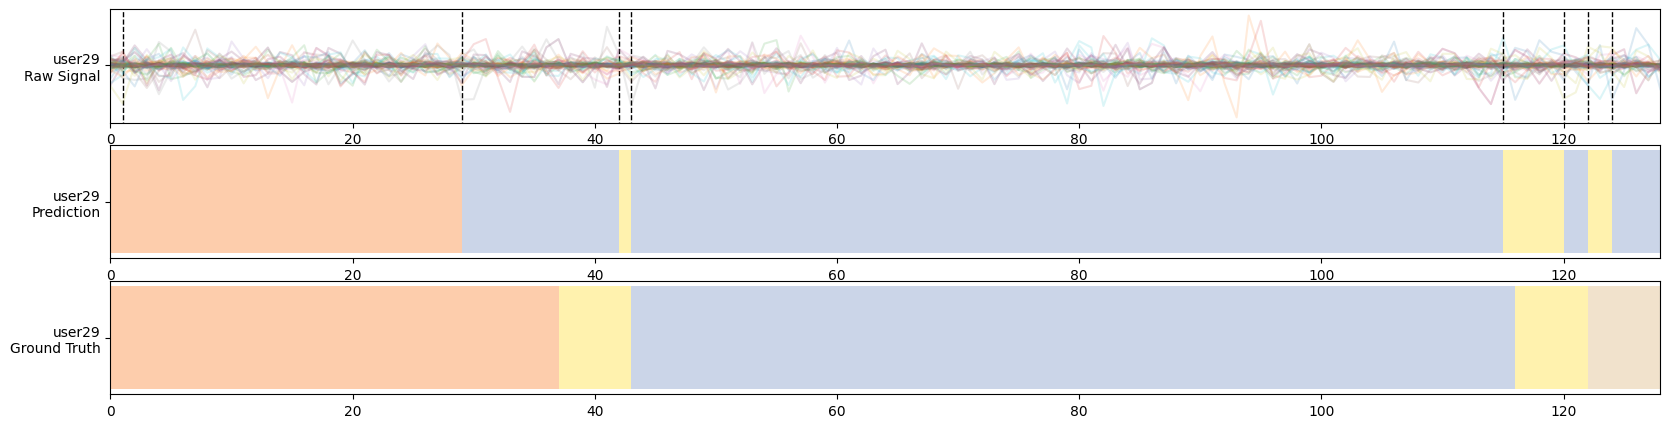

In [5]:
'''
root_dir = "/home/dilab/data/etri/daywise"
test_dir = os.path.join(root_dir, 'test')
'''
f_name = 'user29_1600302600.npz'
device = 'cpu'
n_iter = 0
predlist, lbllist, x, x2  = get_pred(device, 'user29_1600302600.npz', n_iter)

print(x2.shape)
##### Plot Prediction Result 
user_segmentation_vis(predlist, lbllist, x, x2, vis_title = f_name[:6], line_width=1, mode = 'label_all')

##### Plot Ground Truth Result 
#user_segmentation_vis(lbllist,lbllist, x, x2,  vis_title = f_name[:6], line_width=1, mode = 'label_all')